In [ ]:
!pip install catboost

In [ ]:
!pip install optuna --quiet

In [ ]:
pip install --upgrade scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

#Modeling
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

#Advanced models
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool


import optuna

import warnings
warnings.filterwarnings('ignore')

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Mining/store-sales-time-series-forecasting/train.csv", parse_dates=["date"])
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Mining/store-sales-time-series-forecasting/test.csv", parse_dates=["date"])
stores_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Mining/store-sales-time-series-forecasting/stores.csv")
oil_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Mining/store-sales-time-series-forecasting/oil.csv", parse_dates=["date"])
holidays_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Mining/store-sales-time-series-forecasting/holidays_events.csv", parse_dates=["date"])
submission_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Mining/store-sales-time-series-forecasting/sample_submission.csv")

**1. Load Data**

In [ ]:
def load_data():
  train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Mining/store-sales-time-series-forecasting/train.csv", parse_dates=["date"])
  test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Mining/store-sales-time-series-forecasting/test.csv", parse_dates=["date"])
  stores = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Mining/store-sales-time-series-forecasting/stores.csv")
  oil = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Mining/store-sales-time-series-forecasting/oil.csv", parse_dates=["date"])
  holidays = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Mining/store-sales-time-series-forecasting/holidays_events.csv", parse_dates=["date"])
  submission = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Mining/store-sales-time-series-forecasting/sample_submission.csv")
  return train, test, stores, oil, holidays, submission

**Exploratory Data Analysis (EDA)**

In [ ]:
def basic_eda_info(df, name="DataFrame"):

    print(f"=== {name}: Basic Information ===")
    print(f"Shape: {df.shape}")

    print('='*60)
    display(df.head())
    print('='*60)
    display(df.tail())

    with pd.option_context('display.float_format', '{:,.2f}'.format):
        print("Numeric Describe:")
        display(df.describe())

    print('='*60)
    print("Missing Values:")
    print(df.isna().sum())
    print('='*60)

In [ ]:
basic_eda_info(train_df, name="Train")

In [ ]:
basic_eda_info(test_df, name="Test")

In [ ]:
def check_date_range(df, date_col='date'):

    print(f"Date range: {df[date_col].min()} to {df[date_col].max()}")

    total_days = (df[date_col].max() - df[date_col].min()).days + 1
    unique_days = df[date_col].nunique()
    print(f"Total possible days in range: {total_days}, actual unique days: {unique_days}")
    print("="*60)

In [ ]:
check_date_range(train_df, 'date')
check_date_range(test_df, 'date')

In [ ]:
def plot_sales_distribution(df, target_col='sales'):

    fig, axes = plt.subplots(1, 2, figsize=(14,5))

    sns.histplot(df[target_col], bins=50, kde=True, ax=axes[0])
    axes[0].set_title(f"Distribution of {target_col}")

    sns.boxplot(x=df[target_col], ax=axes[1])
    axes[1].set_title(f"Boxplot of {target_col}")

    plt.tight_layout()
    plt.show()

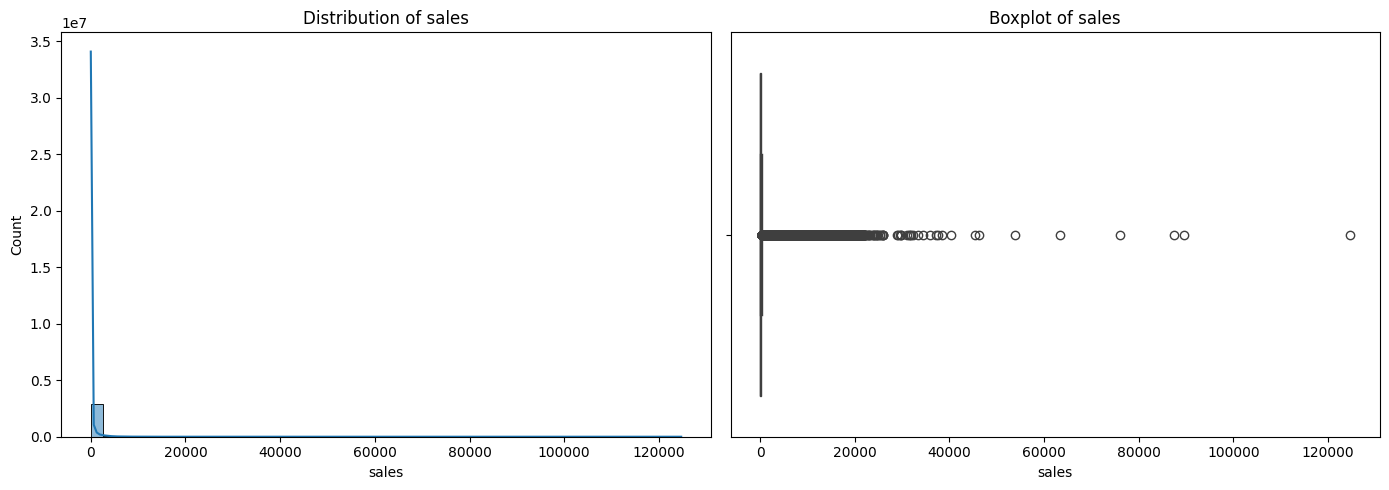

In [ ]:
plot_sales_distribution(train_df, 'sales')

In [ ]:
def grouped_statistics(df, group_cols, value_col='sales', top_n=10):

    group_stats = (
        df.groupby(group_cols)[value_col]
            .agg(
                count='count',
                mean='mean',
                std='std',
                min='min',
                max='max',
                median='median',
                q1=lambda x: x.quantile(0.25),
                q2=lambda x: x.quantile(0.75),
                iqr=lambda x: x.quantile(0.75) - x.quantile(0.25)
            ).reset_index()
    )
    group_stats_sorted = group_stats.sort_values('mean', ascending=False)

    with pd.option_context('display.float_format', '{:,.2f}'.format):
        print(f"Grouped stats by {group_cols}:")
        display(group_stats_sorted.head(top_n))
        print("="*60)

In [ ]:
grouped_statistics(train_df, ['store_nbr'], 'sales', top_n=10)
grouped_statistics(train_df, ['family'], 'sales', top_n=10)
grouped_statistics(train_df, ['onpromotion'], 'sales', top_n=10)

In [ ]:
def plot_time_series(df, date_col='date', target_col='sales', agg='sum', title='Total Sales Over Time'):

    if agg == 'sum':
        daily = df.groupby(date_col)[target_col].sum().reset_index()
    elif agg == 'mean':
        daily = df.groupby(date_col)[target_col].mean().reset_index()
    else:
        raise ValueError("agg must be 'sum' or 'mean', or implement more if needed")

    daily = daily.sort_values(date_col)

    plt.figure(figsize=(12,6))
    plt.plot(daily[date_col], daily[target_col], marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel=(date_col)
    plt.ylabel(target_col)
    plt.show()

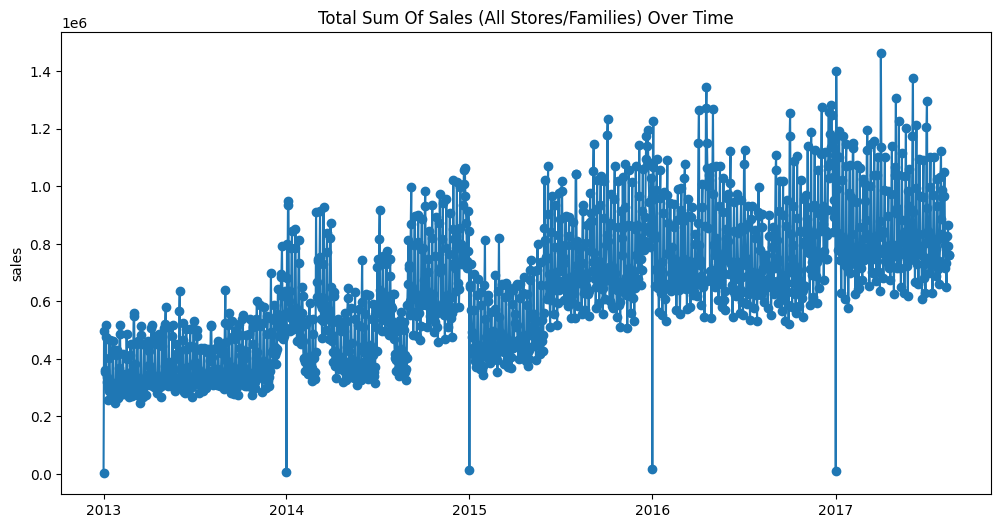

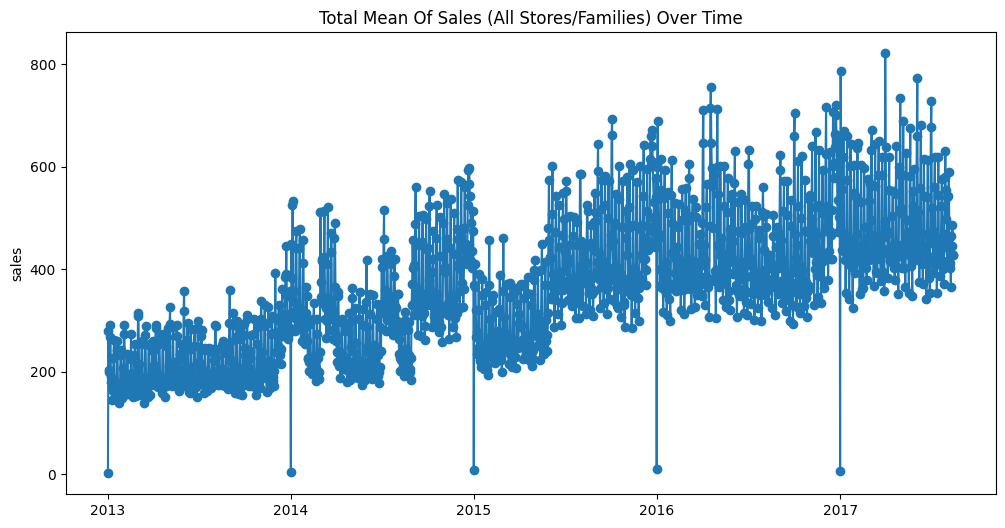

In [ ]:
plot_time_series(train_df, 'date', 'sales', agg='sum', title='Total Sum Of Sales (All Stores/Families) Over Time')
plot_time_series(train_df, 'date', 'sales', agg='mean', title='Total Mean Of Sales (All Stores/Families) Over Time')

In [ ]:
Q1 = train_df['sales'].quantile(0.25)
Q3 = train_df['sales'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

train_df['outlier_iqr'] = (train_df['sales'] < lower_bound) | (train_df['sales'] > upper_bound)

outliers_df = train_df[train_df['outlier_iqr']]
display(outliers_df)

,id,date,store_nbr,family,sales,onpromotion,outlier_iqr
564,564,2013-01-01,25,BEVERAGES,810.000,0,True
573,573,2013-01-01,25,GROCERY I,700.000,0,True
1785,1785,2013-01-02,1,BEVERAGES,1091.000,0,True
1789,1789,2013-01-02,1,CLEANING,1060.000,0,True
1790,1790,2013-01-02,1,DAIRY,579.000,0,True
...,...,...,...,...,...,...,...
3000863,3000863,2017-08-15,9,DAIRY,835.000,19,True
3000864,3000864,2017-08-15,9,DELI,551.713,7,True
3000867,3000867,2017-08-15,9,GROCERY I,6630.383,62,True
3000880,3000880,2017-08-15,9,PERSONAL CARE,522.000,11,True


**Data Cleaning**

In [ ]:
print("Missing in stores_df:")
print(stores_df.isnull().sum())

print("stores_df:")
display(stores_df.head())

print("Missing in oil_df:")
print(oil_df.isnull().sum())

print("oil_df:")
display(oil_df.head())

print("Missing in holidays_df:")
print(holidays_df.isnull().sum())

print("holidays_df:")
display(holidays_df.head())

Missing in stores_df:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
stores_df:


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


Missing in oil_df:
date           0
dcoilwtico    43
dtype: int64
oil_df:


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


Missing in holidays_df:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
holidays_df:


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


Below code fills missing values in the 'dcoilwtico' (oil price) column using linear interpolation, estimating missing values based on surrounding data points in both forward and backward directions. Linear interpolation estimates missing values by drawing a straight line between the nearest known values. If a value is missing, it is filled by assuming a constant rate of change between the surrounding data points. For example, if oil prices on two consecutive days are 50 and 54, but the value for the day in between is missing, linear interpolation would fill it with 52.



In [ ]:
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].interpolate(
    methode='linear',
    limit_direction='both'
)
print("Display oil_df:")
display(oil_df)

print("--"*50)

print("Missing in oil_df:")
print(oil_df.isnull().sum())

Display oil_df:


,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


----------------------------------------------------------------------------------------------------
Missing in oil_df:
date          0
dcoilwtico    0
dtype: int64


**Feature Engineering**

train_df['is_train'] = 1:

This line adds a new column is_train to the train_df DataFrame and sets all values in this column to 1.
This column is used to indicate that the data comes from the training set.

test_df['is_train'] = 0:

This adds a new column is_train to the test_df DataFrame and sets all values in this column to 0.
This column is used to indicate that the data comes from the test set.

This code combines the training and test datasets into one DataFrame, adding identifiers for which rows belong to the training and which to the test set.

In [ ]:
train_df['is_train'] = 1
test_df['is_train'] = 0

test_df['sales'] = np.nan

full_df = pd.concat([train_df, test_df], ignore_index=True)
print("Full data shape (train+test):", full_df.shape)

Full data shape (train+test): (3029400, 8)


After running this function:

The full_df will have:
Store metadata from stores_df.
Oil prices from oil_df.
Holiday information, where is_holiday will be 1 for holidays and 0 for regular days.

In [ ]:
def merge_data(df):

    df = df.merge(stores_df, on='store_nbr', how='left')
    df = df.merge(oil_df, on='date', how='left')

    holidays_cp = holidays_df.copy()
    holidays_cp['is_holiday'] = 1
    holidays_cp = holidays_cp[['date','type','locale','locale_name','description','is_holiday']]
    df = df.merge(holidays_cp, on='date', how='left')
    df['is_holiday'].fillna(0, inplace=True)

    return df

full_df = merge_data(full_df)
full_df

,id,date,store_nbr,family,sales,onpromotion,outlier_iqr,is_train,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,is_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,False,1,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,1.0
1,1,2013-01-01,1,BABY CARE,0.0,0,False,1,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,1.0
2,2,2013-01-01,1,BEAUTY,0.0,0,False,1,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,1.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,False,1,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,1.0
4,4,2013-01-01,1,BOOKS,0.0,0,False,1,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3082855,3029395,2017-08-31,9,POULTRY,NaN,1,NaN,0,Quito,Pichincha,B,6,47.26,NaN,NaN,NaN,NaN,0.0
3082856,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,NaN,0,Quito,Pichincha,B,6,47.26,NaN,NaN,NaN,NaN,0.0
3082857,3029397,2017-08-31,9,PRODUCE,NaN,1,NaN,0,Quito,Pichincha,B,6,47.26,NaN,NaN,NaN,NaN,0.0
3082858,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,NaN,0,Quito,Pichincha,B,6,47.26,NaN,NaN,NaN,NaN,0.0


This code extracts time-based features from the date column in full_df, which helps a machine learning model capture temporal patterns.

Since dayofweek and month are cyclical (e.g., Monday comes after Sunday, and January follows December), we apply sine and cosine transformations to encode these relationships.

Why use sine and cosine?

Helps the model understand that Sunday (6) is close to Monday (0).

Helps preserve the cyclical nature of months (December is close to January).

Converts categorical time-based variables into a format that works well in machine learning models.

In [ ]:
full_df['year'] = full_df['date'].dt.year
full_df['month'] = full_df['date'].dt.month
full_df['day'] = full_df['date'].dt.day
full_df['dayofweek'] = full_df['date'].dt.dayofweek# Extracts the day of the week (0=Monday, 6=Sunday)
full_df['dayofyear'] = full_df['date'].dt.dayofyear # Extracts the day of the year (1-365)
full_df['weekofyear'] = full_df['date'].dt.isocalendar().week.astype(int)# Extracts the week number (1-53)

full_df['dayofweek_sin'] = np.sin(2 * np.pi * full_df['dayofweek']/7)
full_df['dayofweek_cos'] = np.cos(2 * np.pi * full_df['dayofweek']/7)
full_df['month_sin'] = np.sin(2 * np.pi * full_df['month']/12)
full_df['month_cos'] = np.cos(2 * np.pi * full_df['month']/12)

full_df

,id,date,store_nbr,family,sales,onpromotion,outlier_iqr,is_train,city,state,...,year,month,day,dayofweek,dayofyear,weekofyear,dayofweek_sin,dayofweek_cos,month_sin,month_cos
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,False,1,Quito,Pichincha,...,2013,1,1,1,1,1,0.781831,0.623490,0.500000,0.866025
1,1,2013-01-01,1,BABY CARE,0.0,0,False,1,Quito,Pichincha,...,2013,1,1,1,1,1,0.781831,0.623490,0.500000,0.866025
2,2,2013-01-01,1,BEAUTY,0.0,0,False,1,Quito,Pichincha,...,2013,1,1,1,1,1,0.781831,0.623490,0.500000,0.866025
3,3,2013-01-01,1,BEVERAGES,0.0,0,False,1,Quito,Pichincha,...,2013,1,1,1,1,1,0.781831,0.623490,0.500000,0.866025
4,4,2013-01-01,1,BOOKS,0.0,0,False,1,Quito,Pichincha,...,2013,1,1,1,1,1,0.781831,0.623490,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3082855,3029395,2017-08-31,9,POULTRY,NaN,1,NaN,0,Quito,Pichincha,...,2017,8,31,3,243,35,0.433884,-0.900969,-0.866025,-0.500000
3082856,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,NaN,0,Quito,Pichincha,...,2017,8,31,3,243,35,0.433884,-0.900969,-0.866025,-0.500000
3082857,3029397,2017-08-31,9,PRODUCE,NaN,1,NaN,0,Quito,Pichincha,...,2017,8,31,3,243,35,0.433884,-0.900969,-0.866025,-0.500000
3082858,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,NaN,0,Quito,Pichincha,...,2017,8,31,3,243,35,0.433884,-0.900969,-0.866025,-0.500000


In [ ]:
full_df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'outlier_iqr', 'is_train', 'city', 'state', 'type_x', 'cluster',
       'dcoilwtico', 'type_y', 'locale', 'locale_name', 'description',
       'is_holiday', 'year', 'month', 'day', 'dayofweek', 'dayofyear',
       'weekofyear', 'dayofweek_sin', 'dayofweek_cos', 'month_sin',
       'month_cos'],
      dtype='object')

This code is used for detecting and marking outliers in the dataset based on a signature-matching approach. It first identifies outliers in the training set, creates a unique signature for each outlier, and then checks whether the same signatures exist in the full dataset (including both training and test sets).

This process identifies and flags outliers (is_outlier = True) in both train and test datasets.
Ensures that any pattern found as an outlier in training is applied consistently across the dataset.

In [ ]:
MATCH_COLS = [
    'store_nbr', 'family', 'onpromotion',
    'city', 'state', 'type_x', 'cluster', 'dcoilwtico',
    'type_y', 'locale', 'locale_name', 'description',
    'is_holiday', 'month', 'day', 'dayofweek',
    'dayofyear', 'weekofyear', 'dayofweek_sin',
    'dayofweek_cos', 'month_sin', 'month_cos'
]

# 1) Filter train outliers (where 'is_train'==1)
train_outliers = full_df[(full_df['outlier_iqr'] == True) & (full_df['is_train'] == 1)]

# 2) Create a single "signature" column in the outlier subset
#    Convert each MATCH_COL to string, then join them with a special delimiter.
train_outliers['signature'] = train_outliers[MATCH_COLS].astype(str).apply(lambda row: '_'.join(row), axis=1)

# 3) Build a set of signatures
outlier_signatures = set(train_outliers['signature'].tolist())

print(f"Number of unique outlier signatures in train: {len(outlier_signatures)}")

# 4) Now build the signature for *all* rows (train+test) in full_df
full_df['signature'] = full_df[MATCH_COLS].astype(str).apply(lambda row: '_'.join(row), axis=1)

# 5) Finally, check membership with .isin(...)
full_df['is_outlier'] = full_df['signature'].isin(outlier_signatures)

# (Optionally, drop the temporary columns if you like)
# full_df.drop(columns=['signature'], inplace=True)

full_df.drop(columns=['signature', 'outlier_iqr'], inplace=True)

display(full_df.head())

Number of unique outlier signatures in train: 455936


,id,date,store_nbr,family,sales,onpromotion,is_train,city,state,type_x,...,month,day,dayofweek,dayofyear,weekofyear,dayofweek_sin,dayofweek_cos,month_sin,month_cos,is_outlier
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,Quito,Pichincha,D,...,1,1,1,1,1,0.781831,0.62349,0.5,0.866025,False
1,1,2013-01-01,1,BABY CARE,0.0,0,1,Quito,Pichincha,D,...,1,1,1,1,1,0.781831,0.62349,0.5,0.866025,False
2,2,2013-01-01,1,BEAUTY,0.0,0,1,Quito,Pichincha,D,...,1,1,1,1,1,0.781831,0.62349,0.5,0.866025,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,1,Quito,Pichincha,D,...,1,1,1,1,1,0.781831,0.62349,0.5,0.866025,False
4,4,2013-01-01,1,BOOKS,0.0,0,1,Quito,Pichincha,D,...,1,1,1,1,1,0.781831,0.62349,0.5,0.866025,False


This code converts categorical columns into numerical codes and maps holiday types to numeric values. First, it iterates through a list of categorical columns such as 'family', 'city', 'state', and others, converting each into numeric codes using .astype('category').cat.codes, which assigns a unique integer to each category for machine learning compatibility. Next, it creates a mapping of unique holiday types from the holidays_df dataframe by assigning each type a numerical index. This mapping is then used to transform the 'type_y' column in full_df into corresponding numerical values. If any holiday type is missing (NaN), it means there was no matching holiday type for that row.

In [ ]:
cat_cols = ['family', 'city', 'state', 'type_x', 'type_y', 'locale', 'locale_name', 'description', 'is_outlier']
for col in cat_cols:
    full_df[col] = full_df[col].astype('category').cat.codes

holiday_types = holidays_df['type'].unique().tolist()
type_map = {t: i for i, t in enumerate(holiday_types)}
full_df['holiday_type'] = full_df['type_y'].map(type_map)

full_df

,id,date,store_nbr,family,sales,onpromotion,is_train,city,state,type_x,...,day,dayofweek,dayofyear,weekofyear,dayofweek_sin,dayofweek_cos,month_sin,month_cos,is_outlier,holiday_type
0,0,2013-01-01,1,0,0.0,0,1,18,12,3,...,1,1,1,1,0.781831,0.623490,0.500000,0.866025,0,NaN
1,1,2013-01-01,1,1,0.0,0,1,18,12,3,...,1,1,1,1,0.781831,0.623490,0.500000,0.866025,0,NaN
2,2,2013-01-01,1,2,0.0,0,1,18,12,3,...,1,1,1,1,0.781831,0.623490,0.500000,0.866025,0,NaN
3,3,2013-01-01,1,3,0.0,0,1,18,12,3,...,1,1,1,1,0.781831,0.623490,0.500000,0.866025,0,NaN
4,4,2013-01-01,1,4,0.0,0,1,18,12,3,...,1,1,1,1,0.781831,0.623490,0.500000,0.866025,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3082855,3029395,2017-08-31,9,28,NaN,1,0,18,12,1,...,31,3,243,35,0.433884,-0.900969,-0.866025,-0.500000,0,NaN
3082856,3029396,2017-08-31,9,29,NaN,0,0,18,12,1,...,31,3,243,35,0.433884,-0.900969,-0.866025,-0.500000,0,NaN
3082857,3029397,2017-08-31,9,30,NaN,1,0,18,12,1,...,31,3,243,35,0.433884,-0.900969,-0.866025,-0.500000,0,NaN
3082858,3029398,2017-08-31,9,31,NaN,9,0,18,12,1,...,31,3,243,35,0.433884,-0.900969,-0.866025,-0.500000,0,NaN


 Final Features Selection

In [ ]:
train_final = full_df[full_df['is_train'] == 1].copy()
test_final  = full_df[full_df['is_train'] == 0].copy()
print("train_final shape:", train_final.shape)
print("test_final shape :", test_final.shape)

train_final shape: (3054348, 29)
test_final shape : (28512, 29)


In [ ]:
features = [
    'store_nbr', 'family', 'onpromotion', 'city','state','type_x','type_y','cluster',
    'dcoilwtico', 'is_holiday', 'holiday_type',
    'year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear',
    'dayofweek_sin','dayofweek_cos','month_sin','month_cos','is_outlier'
]

target = 'sales'

train_final = train_final.sort_values(by=['date','store_nbr','family']).reset_index(drop=True)
X = train_final[features]
y = np.log1p(train_final[target])

print('X (features):')
display(X)
print('')
print('--'*50)
print('')
print('y (target):')
display(y)

X (features):


,store_nbr,family,onpromotion,city,state,type_x,type_y,cluster,dcoilwtico,is_holiday,...,month,day,dayofweek,dayofyear,weekofyear,dayofweek_sin,dayofweek_cos,month_sin,month_cos,is_outlier
0,1,0,0,18,12,3,3,13,93.14,1.0,...,1,1,1,1,1,0.781831,0.62349,0.500000,0.866025,0
1,1,1,0,18,12,3,3,13,93.14,1.0,...,1,1,1,1,1,0.781831,0.62349,0.500000,0.866025,0
2,1,2,0,18,12,3,3,13,93.14,1.0,...,1,1,1,1,1,0.781831,0.62349,0.500000,0.866025,0
3,1,3,0,18,12,3,3,13,93.14,1.0,...,1,1,1,1,1,0.781831,0.62349,0.500000,0.866025,0
4,1,4,0,18,12,3,3,13,93.14,1.0,...,1,1,1,1,1,0.781831,0.62349,0.500000,0.866025,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,54,28,0,5,10,2,3,3,47.57,1.0,...,8,15,1,227,33,0.781831,0.62349,-0.866025,-0.500000,0
3054344,54,29,0,5,10,2,3,3,47.57,1.0,...,8,15,1,227,33,0.781831,0.62349,-0.866025,-0.500000,0
3054345,54,30,76,5,10,2,3,3,47.57,1.0,...,8,15,1,227,33,0.781831,0.62349,-0.866025,-0.500000,1
3054346,54,31,0,5,10,2,3,3,47.57,1.0,...,8,15,1,227,33,0.781831,0.62349,-0.866025,-0.500000,0



----------------------------------------------------------------------------------------------------

y (target):


,sales
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
3054343,4.104608
3054344,4.553877
3054345,6.820421
3054346,0.000000


**Time-Based Cross-Validation**

This code performs time series cross-validation using TimeSeriesSplit. It splits the dataset (X, y) into 3 sequential train-validation splits while maintaining the time order. In each fold:

train_idx contains the indices of the training data for that fold.
val_idx contains the indices of the validation data for that fold.
The sizes of both sets are printed for each fold.

In [ ]:
tscv = TimeSeriesSplit(n_splits=3)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X,y)):
    print(f"Fold {fold}")
    print(f"Train size : {len(train_idx)} | Validation size : {len(val_idx)}")

**Modeling**

**XGBoost Model**

This code defines an objective function for tuning XGBoost hyperparameters using Optuna and TimeSeriesSplit for cross-validation.

In [ ]:
def objective_xgb(trial):
    """
    Objective function for Optuna hyperparameter tuning of XGBoost.
    """

    # Suggest hyperparameters
    param = {
        'objective': 'reg:squarederror',
        'tree_method': 'hist',  # if GPU is available, else use 'hist'
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'early_stopping_rounds':50
    }

    rmse_scores = []

    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=3)
    for train_idx, val_idx in tscv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = xgb.XGBRegressor(**param)
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  verbose=False)

        y_pred = model.predict(X_val)
        y_pred = np.expm1(y_pred)
        y_val = np.expm1(y_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=5)

print("XGBoost best params:", study_xgb.best_params)
print("XGBoost best score:", study_xgb.best_value)

In [ ]:
import json

# Save best parameters to a JSON file
with open("best_xgb_params.json", "w") as f:
    json.dump(study_xgb.best_params, f)


Train Final XGBoost Model with Best Params

In [ ]:
import json
with open("best_xgb_params.json", "r") as f:
    best_xgb_params = json.load(f)

# Initialize and train the model with the loaded parameters
final_xgb = xgb.XGBRegressor(**best_xgb_params)
final_xgb.fit(X, y)

In [ ]:
best_xgb_params = study_xgb.best_params
final_xgb = xgb.XGBRegressor(**best_xgb_params)
final_xgb.fit(X, y)

**LightGBM Model**

In [ ]:
def objective_lgb(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    rmse_scores = []
    tscv = TimeSeriesSplit(n_splits=3)
    for train_idx, val_idx in tscv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        lgb_train = lgb.Dataset(X_train, label=y_train)
        lgb_val = lgb.Dataset(X_val, label=y_val)

        model = lgb.LGBMRegressor(**param)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='rmse',
            callbacks=[lgb.early_stopping(50)]
        )

        y_pred = model.predict(X_val)
        y_pred = np.expm1(y_pred)
        y_val = np.expm1(y_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=5)
print("LGBM best params:", study_lgb.best_params)
print("LGBM best score:", study_lgb.best_value)

In [ ]:
# Save best parameters to a JSON file
with open("lgb_best_params.json", "w") as f:
    json.dump(study_lgb.best_params, f)


In [ ]:
best_lgb_params = study_lgb.best_params
final_lgb = lgb.LGBMRegressor(**best_lgb_params)
final_lgb.fit(X, y)

In [ ]:
import json
with open("lgb_best_params.json", "r") as f:
    lgb_best_params = json.load(f)

# Initialize and train the model with the loaded parameters
final_lgb = xgb.XGBRegressor(**lgb_best_params)
final_lgb.fit(X, y)

**CatBoost Model**

In [ ]:
def objective_cat(trial):
    param = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "loss_function": "RMSE",
        "verbose": False,
    }

    rmse_scores = []

    tscv = TimeSeriesSplit(n_splits=3)  # or any other CV strategy
    for train_idx, val_idx in tscv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        train_pool = Pool(X_train, label=y_train)
        val_pool = Pool(X_val, label=y_val)

        model = CatBoostRegressor(**param)
        model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=False)

        y_pred = model.predict(X_val)
        y_pred = np.expm1(y_pred)
        y_val = np.expm1(y_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)


    return np.mean(rmse_scores)

study_cat = optuna.create_study(direction="minimize", study_name="catboost-tuning")
study_cat.optimize(objective_cat, n_trials=5, show_progress_bar=True)
print("CatBoost best params:", study_cat.best_params)
print("CatBoost best score:", study_cat.best_value)

In [ ]:
# Save best parameters to a JSON file
with open("cat_best_params.json", "w") as f:
    json.dump(study_cat.best_params, f)

In [ ]:
best_cat_params = study_cat.best_params
final_cat_model = CatBoostRegressor(**best_cat_params)
final_cat_model.fit(X, y, verbose=False)

In [ ]:
import json
with open("cat_best_params.json", "r") as f:
    cat_best_params = json.load(f)

# Initialize and train the model with the loaded parameters
final_cat_model = xgb.XGBRegressor(**cat_best_params)
final_cat_model.fit(X, y)

In [ ]:
xgb_preds_log = ""
lgb_preds_log = ""
cat_preds_log = ""

**Ensembling**

This code gets predictions from three models (XGBoost, LightGBM, CatBoost).
Converts predictions from log scale to the original scale.
Averages the predictions to create an ensemble model.
Computes RMSE to evaluate the ensemble's performance.

In [ ]:
xgb_preds_log = final_xgb.predict(X)
lgb_preds_log = final_lgb.predict(X)
cat_preds_log = final_cat_model.predict(X)

xgb_preds_log = np.clip(xgb_preds_log, -20, 20)
lgb_preds_log = np.clip(lgb_preds_log, -20, 20)
cat_preds_log = np.clip(cat_preds_log, -20, 20)

xgb_preds = np.expm1(xgb_preds_log)
lgb_preds = np.expm1(lgb_preds_log)
cat_preds = np.expm1(cat_preds_log)

ensemble_preds = (xgb_preds + lgb_preds + cat_preds)/3

y = np.expm1(y)

mse = mean_squared_error(y, ensemble_preds)
ensemble_rmse = np.sqrt(mse)
print("Ensemble RMSE (on full training set): ", ensemble_rmse)

In [ ]:
xgb_preds_log = final_xgb.predict(X)
lgb_preds_log = final_lgb.predict(X)
cat_preds_log = final_cat_model.predict(X)

xgb_preds = np.expm1(xgb_preds_log)
lgb_preds = np.expm1(lgb_preds_log)
cat_preds = np.expm1(cat_preds_log)

ensemble_preds = (xgb_preds + lgb_preds + cat_preds)/3

y = np.expm1(y)

mse = mean_squared_error(y, ensemble_preds)
ensemble_rmse = np.sqrt(mse)
print("Ensemble RMSE (on full training set): ", ensemble_rmse)

**Prediction and Submission**

In [ ]:
test_final = test_final.sort_values(by=['date','store_nbr','family']).reset_index(drop=True)
X_test = test_final[features].copy()
X_test

,store_nbr,family,onpromotion,city,state,type_x,type_y,cluster,dcoilwtico,is_holiday,...,month,day,dayofweek,dayofyear,weekofyear,dayofweek_sin,dayofweek_cos,month_sin,month_cos,is_outlier
0,1,0,0,18,12,3,-1,13,46.80,0.0,...,8,16,2,228,33,0.974928,-0.222521,-0.866025,-0.5,0
1,1,1,0,18,12,3,-1,13,46.80,0.0,...,8,16,2,228,33,0.974928,-0.222521,-0.866025,-0.5,0
2,1,2,2,18,12,3,-1,13,46.80,0.0,...,8,16,2,228,33,0.974928,-0.222521,-0.866025,-0.5,0
3,1,3,20,18,12,3,-1,13,46.80,0.0,...,8,16,2,228,33,0.974928,-0.222521,-0.866025,-0.5,0
4,1,4,0,18,12,3,-1,13,46.80,0.0,...,8,16,2,228,33,0.974928,-0.222521,-0.866025,-0.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,54,28,0,5,10,2,-1,3,47.26,0.0,...,8,31,3,243,35,0.433884,-0.900969,-0.866025,-0.5,0
28508,54,29,0,5,10,2,-1,3,47.26,0.0,...,8,31,3,243,35,0.433884,-0.900969,-0.866025,-0.5,0
28509,54,30,1,5,10,2,-1,3,47.26,0.0,...,8,31,3,243,35,0.433884,-0.900969,-0.866025,-0.5,0
28510,54,31,0,5,10,2,-1,3,47.26,0.0,...,8,31,3,243,35,0.433884,-0.900969,-0.866025,-0.5,0


In [ ]:
xgb_test_preds_log = final_xgb.predict(X_test)
lgb_test_preds_log = final_lgb.predict(X_test)
cat_test_preds_log = final_cat_model.predict(X_test)

xgb_test_preds = np.expm1(xgb_test_preds_log)
lgb_test_preds = np.expm1(lgb_test_preds_log)
cat_test_preds = np.expm1(cat_test_preds_log)

ensemble_test_preds = (xgb_test_preds + xgb_test_preds + xgb_test_preds)/3

submission_df = test_df[['id']].copy()
submission_df['sales'] = ensemble_test_preds

display(submission_df)
print("--"*50)
display(submission_df.describe())

,id,sales
0,3000888,3.510268
1,3000889,0.034929
2,3000890,5.467889
3,3000891,461.525665
4,3000892,0.071501
...,...,...
28507,3029395,42.900864
28508,3029396,51.354473
28509,3029397,332.516052
28510,3029398,0.155527


----------------------------------------------------------------------------------------------------


,id,sales
count,2.851200e+04,28512.000000
mean,3.015144e+06,127.259445
std,8.230850e+03,191.120316
min,3.000888e+06,-0.680451
25%,3.008016e+06,3.475164
50%,3.015144e+06,22.392841
75%,3.022271e+06,201.912582
max,3.029399e+06,1582.247437


In [ ]:
submission_df.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")

Submission file created: submission.csv
